In [ ]:
!pip install  numpy transformer_lens

from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

model = HookedTransformer.from_pretrained("gpt2-small")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
def get_token_trajectory(text: str, token_index: int) -> list[dict]:
  """Returns the residual stream vector for one token at each layer."""
  _, cache = model.run_with_cache(text)
  n_layers = model.cfg.n_layers # 12 for GPT-2 small
  trajectory = []
  for layer in range(n_layers):
    embedding = cache["resid_post", layer][0, token_index, :]
    trajectory.append({"layer": layer,
    "embedding": embedding.tolist() # convert tensor to list
    })
  return trajectory

#function of Get_token_trajectory
---
this function extracts the residual stream embedding for a specific token across all layers of the gpt2-small model. and stores it in a dictonary containg the layer number and the extracted embedding


In [ ]:
text = "The cat sat on the mat"
tokens = model.to_str_tokens(text)
print(list(enumerate(tokens)))

[(0, '<|endoftext|>'), (1, 'The'), (2, ' cat'), (3, ' sat'), (4, ' on'), (5, ' the'), (6, ' mat')]


#Understanding tokens
---
the input for LLMs can be broken down into small parts of your input called token. where we use the .to_str_tokens to understand the indexing of the input since tokenization isn't nessesarily broken down into words. as we can see from index 0 '<|endoftext|>'.

In [ ]:
trajectory = get_token_trajectory(text, token_index=2)

In [ ]:
print(f"Layer 0 embedding (first 5 dims): {trajectory[0]['embedding'][:5]}")
print(f"Layer 11 embedding (first 5 dims): {trajectory[11]['embedding'][:5]}")

Layer 0 embedding (first 5 dims): [0.07512637972831726, -0.648972749710083, -0.040394484996795654, 1.4727506637573242, 0.012034885585308075]
Layer 11 embedding (first 5 dims): [-3.1292307376861572, 2.5830016136169434, 2.452510356903076, 3.841452121734619, -2.5713841915130615]


#Output
---
the numbers don't really give anyone any useful info, since it's only the first 5 dim of the vector,so graphing the length of the entire vetor would be a better visual of whats happening for the cat token.

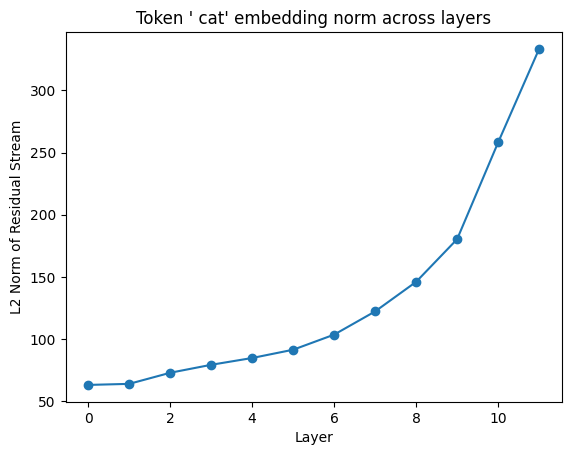

In [ ]:
norms = [torch.tensor(t["embedding"]).norm().item() for t in trajectory]

plt.plot(range(len(norms)), norms, marker='o')
plt.xlabel("Layer")
plt.ylabel("L2 Norm of Residual Stream")
plt.title(f"Token '{tokens[2]}' embedding norm across layers")
plt.show()

#Output of this graph
---
this graph is good to show the length of the embbeding vector which means that the MLP and attention heads are reading and writing to it, increasing the  information to the word across each layer.

In [49]:
for layer_data in trajectory:
    embedding = torch.tensor(layer_data["embedding"])
    # normalize first (like the model does)
    normed = model.ln_final(embedding.unsqueeze(0).unsqueeze(0))
    logits = model.unembed(normed)
    top_token = logits.argmax(dim=-1)
    print(f"Layer {layer_data['layer']}: {model.to_str_tokens(top_token)[0]}")

Layer 0: cat
Layer 1: aclysm
Layer 2: aclysm
Layer 3: aclysm
Layer 4: aclysm
Layer 5: aclysm
Layer 6: aclysm
Layer 7: aclysm
Layer 8: aclysm
Layer 9: aclysm
Layer 10: fish
Layer 11:  was


#Output of the logit
---
The residual stream at each layer is a 768-dimensional vector whose direction encodes what the model is "thinking" about the token. Layer norm strips out the length so only the direction remains, then the unembedding matrix compares that direction against every word in GPT-2's 50,257-word vocabulary via a dot product, producing a score for each token. The token with the highest score is the model's best guess at what word comes next given how far it has processed the input. Converting that winning index back to a string is what gives you the human-readable output like "beside" or ",".